## PW on graphcut optimization (binary case)
This session is divided into 3 parts:


* a part on Bayesian classification (see PW1 and PW2)
* a part on object/background segmentation of a colour image with a CRF (conditional random filed)
* a part on the iterative segmentation of a textured image

We will use the PyMaxflow library for the calculation of the graphcut.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import platform
import tempfile
import os
from scipy import ndimage as ndi
try:
    import maxflow # if not installed, install Maxflow
except:
    !pip install PyMaxflow # For Google Collab
    import maxflow

from skimage import io
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

def display_segmentation_borders(image, bin):
    imagergb = np.copy(image)
    from skimage.morphology import binary_dilation, disk
    contour = binary_dilation(bin,disk(15))^bin
    imagergb[contour==1,0] = 255
    imagergb[contour==1,1] = 0
    imagergb[contour==1,2] = 0
    return imagergb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 8.3 MB/s eta 0:00:00


## Binary classification of a noisy image

You have a binary image *IoriginaleBW.png* (binary image of the two classes) and its observed version with a certain distribution of grey levels for each class *Iobservee.png*. The objective is to perform a two-class classification of this observed image (see PW1 and PW2).

### Analysis of the distributions of the 2 classes of the image}


Q1: What are the distributions of the two classes of the image ($P(Y_s|X_s=0)$ (black class) and $P(Y_s|X_s=0)$ (white class))?

Q2: Give the means and variances of the two classes.

*The distributions and the means and variances found in the previous sessions will be used without justification*.

**Your answer &#x270D;**

A1: The distributions are normal distributions

A2:

for class 0 : mean = $m_0 = 96$ var = $500$

for class 1 : mean = $m_1 = 164$ var = $500$

## 1.1: Graphcut optimization

Q3: How many nodes does the graph have that is constructed for the search for the minimum capacity cut with only two neighbouring pixels? What do they correspond to? What do the data attachment terms in this graph correspond to and what values do they have for two observed pixels of values $y_s$ and $y_t$? What does the regularisation term correspond to?

**Your answer &#x270D;**

A3:

For two neighbouring pixels the graph contains 4 nodes (number of pixels + 2 ) : one for the source node, two representing each pixel and one for the sink node. The data attachement terms corresponds to the weighted edges between the pixel and source node and in this case the weight is  $D(0,y_s)$ or the pixel and the sink node and in this case the weight is $D(1,y_s)$ with D representing the data attachement term in the pixel s. The regularisation term corresponds to a weighted edge between the nodes of the pixels. In our case we only have 2 pixels. So we have an edge between them if and only if the pixels are neighbours. The weight of this edge corresponds to the potentiel of that liason

Q4: Complete the python code cell where it says "#TO BE COMPLETED EX1" with the data attachment and regularization terms as indicated. Run the minimum cut algorithm and view the result.

## 1.2 Searching for the optimal $\beta$.



Q5: By completing the program frame provided below, find the optimal $\beta$ value $\beta_{opt}$ using the "true image" $x$ corresponding to IoriginaleBW.png. You can plot the error values between $x$ and the estimated $\hat{x}$ to find $\beta_{opt}$.



**Your answer &#x270D;**

A5:Best beta value:  1772.4137931034484

Q6: What are the advantages of this optimization approach compared to ICM? Compared to simulated annealing? In theory, do we obtain the same result with both methods (simulated annealing and graphcut)? Under what conditions? What is the advantage of simulated annealing in the general case?

**Your answer &#x270D;**

A6:

The advanatge is that under certain constraint on the form of the energy function, it is guarnteed to get the optimal solution. In oposition, ICM can give us a local optima and can be highly influenced by the intialization.
Compared to simulated annealing, the graph cut approach gives the same optima with much fewer computation.

Under the conditions that in the simulated annealing we start with a sufficiently high tempreture and we decrease very slowly we get the global minima. In the general case the advantage of the simulated annealing is the fact that it doesn't depend on the intialization and when respecting the conditions we get allways the global minima no matter the form of the energy function.



Q7: How can you explain that the error rate with the true image can be lower with the simulated annealing result or the ICM than with the graph-cut optimisation?
  

**Your answer &#x270D;**

A7:
The result obtained by the graph-cut optimisation is a global minimum in general.
If we get lower error rate with ICM or simulated annealing using the same energy expression this can only mean that this expression doesn't respect the constraints needed for the graph-cut to give the global optimum

Q8: What are the advantages and disadvantages of the Ising model?

**Your answer &#x270D;**

A8:
The advanatge of the Ising model is that it is very simple and fast to code. However, the biggest disadvantage is that it tends to gives us locally homogenous zones ( cartoon like images ). In general, real images doesn't respect this condition since we can find several textures and contours in images. So applying the Ising model is not appropiate In general cases

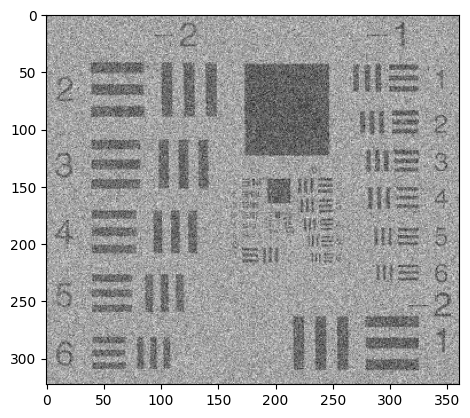

In [2]:
# Loading images
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png") # Observed image, noisy
im_orig=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png") # Binary reference image, to assess the quality of the segmentation

plt.imshow(im_obs,cmap='gray')

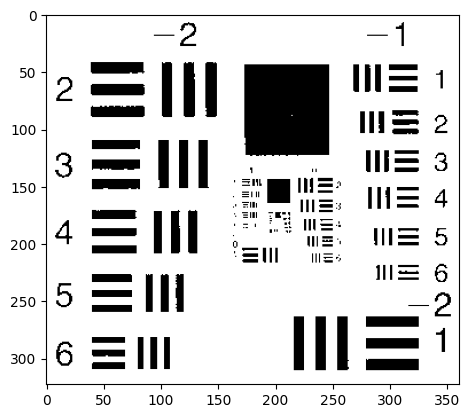

In [3]:
plt.imshow(im_orig, cmap='gray')

In [4]:
#### to be completed
# TO BE COMPLETED EX1
beta = 2100 # beta value
m0 =96.  # m0 and m1 values from the previous practical work
m1 =164.
var = 500

## binary graph-cut

# Create the graph.
g = maxflow.Graph[float]() # Graph instantiation

# Add the nodes.
# nodeids has the identifiers of the nodes in the grid.
# It creates a set of nodes for all the pixels of the image
nodeids = g.add_grid_nodes(im_obs.shape)

# Add non-terminal edges with the same capacity.
# the edge has the value beta for all adjacent pixels in 4-connexity
g.add_grid_edges(nodeids, beta)

# Add the terminal edges.
# the second argument correspond to the set of edge values to the source
# the third argument correspond to the set of edge values to the sink
g.add_grid_tedges(nodeids, (im_obs-m0)**2, (im_obs-m1)**2)

# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the labels of the nodes in the grid.
# output is 0 if the node is connected to the source, else output is 1
sgm = g.get_grid_segments(nodeids)
im_bin = np.int_(np.logical_not(sgm))

Max Flow: 79351589.0


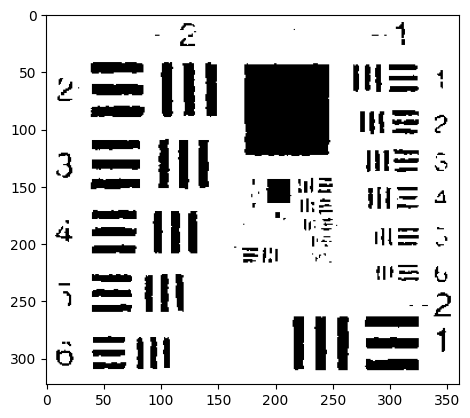

In [5]:
plt.imshow(im_bin,cmap='gray')

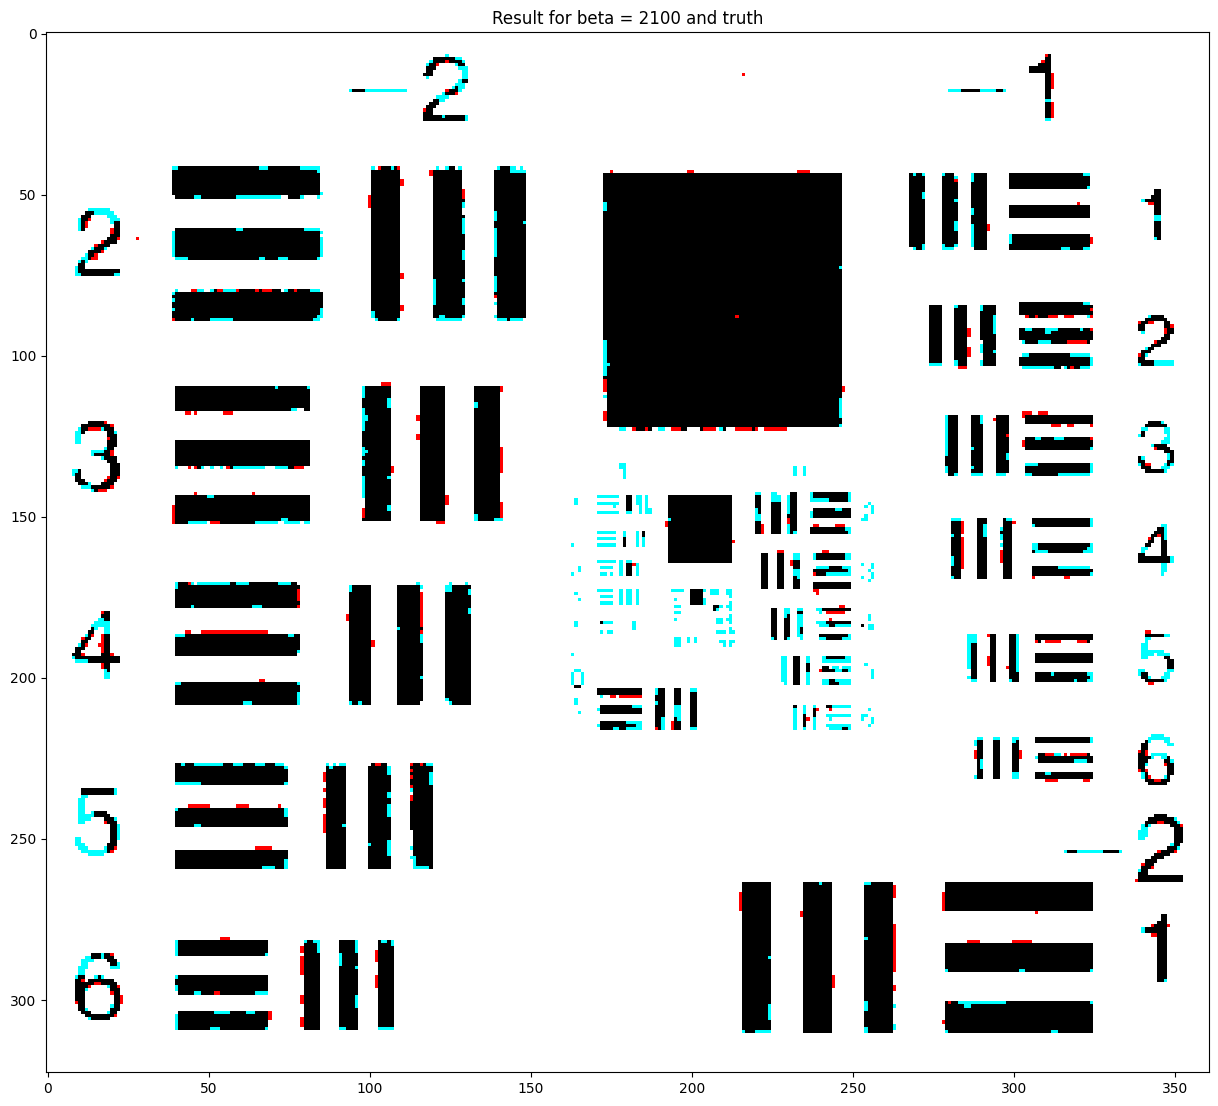

Number of misclassified pixels for beta =  2100 :  2308


In [6]:
# compute the error image between im_bin and im_orig (the ideal solution) using np.abs and np.sum
error = np.sum(np.abs(im_orig-im_bin))
plt.rcParams['figure.figsize'] = [15, 15]
# visualize the differences between the original image and the solution
plt.figure()
plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
plt.title("Result for beta = " + str(beta) + " and truth")
plt.show()

print("Number of misclassified pixels for beta = ",beta,": ",int(error))

### Search for the best parameter $\beta$

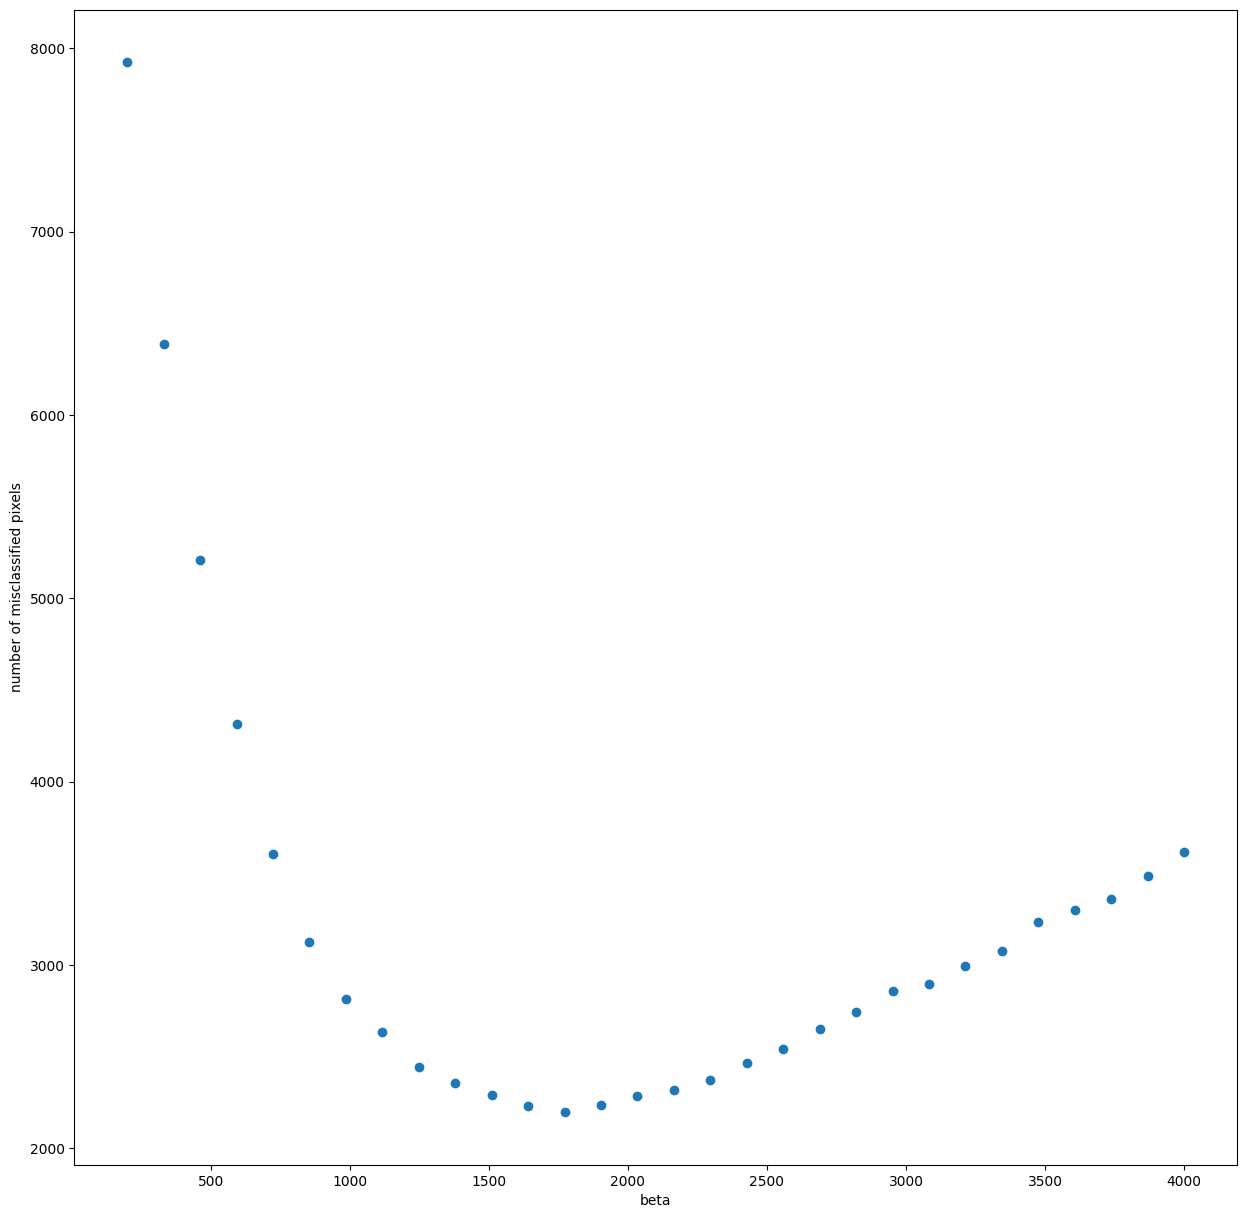

Best beta value:  1772.4137931034484


In [7]:
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png") # Observed image, noisy
im_orig=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png") # Binary reference image, to assess the quality of the segmentation

list_beta = []
list_errors = []

# TO BE COMPLETED - choose a range of values and a step to study beta
for beta in np.linspace(200,4000,30) :
    # TO BE COMPLETED
    m0 =96.
    m1 =164.

    ## Binary graph cut

    # Create the graph
    g = maxflow.Graph[float]() # graph instantiation

    # Add the nodes. nodeids has the identifiers of the nodes in the grid.
    nodeids = g.add_grid_nodes(im_obs.shape)
    # Add non-terminal edges with the same capacity.
    g.add_grid_edges(nodeids,beta)
    # Add the terminal edges.
    #TO BE COMPLETED
    g.add_grid_tedges(nodeids,(im_obs-m0)**2, (im_obs-m1)**2)

    # Find the maximum flow.
    flow = g.maxflow()

    # Get the segments of the nodes in the grid.
    sgm = g.get_grid_segments(nodeids)
    # create the output image
    im_bin = np.int_(np.logical_not(sgm))

    # print("beta = ",beta)
    # compute the error
    #TO BE COMPLETED
    error =np.sum(np.abs(im_bin-im_orig))
    list_beta.append(beta)
    list_errors.append(error)

plt.figure()
plt.scatter(list_beta,list_errors)
plt.xlabel("beta")
plt.ylabel("number of misclassified pixels")
plt.show()

best_beta = list_beta[np.argmin(np.array(list_errors))]

print('Best beta value: ', best_beta)

## 2. Classification of a colour image

The objective of this part is to carry out an extension of the method seen previously in the case of the treatment of a colour image *avions.png* in which one wants to separate the objects from the background.

We will first use the same framework (Ising model) as before but with a three-dimensional data attachment (assuming convariance matrices equal to the identity). Then we will introduce a CRF (conditional random field) by weighting the regularisation term of the Ising model by the modulus of the gradient between two pixels of the observed image.  

### 2.1 Binary classification
From the program structure below, carry out the different steps necessary for this classification:
1. Modelling of the background and object distributions (in 3 dimensions this time)
1. Definition of the data attachment term
1. Choice of a value for the regularisation parameter for the Ising model
1. Finding the minimal cut to obtain the object/background classification.

Q9: Comment on these steps and the results obtained.

**Your answer &#x270D;**

A9:
We model the background and object distributions as random variables that follow normal distribution with different means and nearly the same variance (as we found in the numeric results). Then we define the data attachement term as the sum of the data attachement term coming from each channel. This is justified by our assumption that the covariance matrices are equal to the identity. meanining that the three channels represent independent random variables. Afterwards, in order to choose the beta value without having access to the real image like before , we will try out different masks and visually pick the most appealing one. And finally we can use the graph cut algorithm in order to get the image that minimizes the energy.

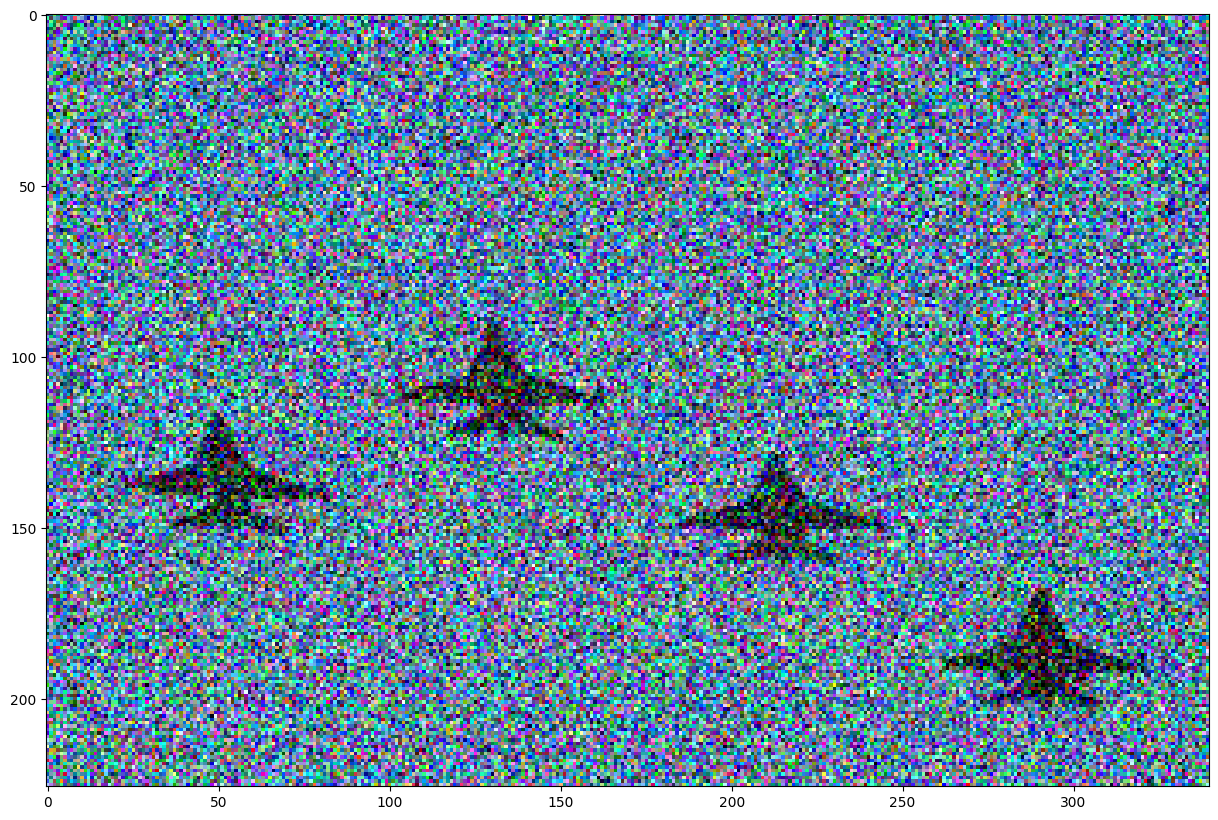

In [8]:
# Loading and displaying the image
#im_planes=io.imread('https://www.dropbox.com/s/ylm0ut8ipu5oonb/avions.png?dl=1')
im_planes=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/planes.png")

plt.figure()
#plt.imshow(im_obs,vmin=0,vmax=255)
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(im_planes)
plt.show()


#### Determining the parameters of the classes


Plane class: we can use the values of the rectangle [180:200,280:300].

example np.mean(image[180:200,280:300,1]) returns the average of the selected area for channel 1

In [9]:
# mean of the plane class - 3D vector
# TO BE COMPLETED
#m_planes =im_planes[180:200,280:300]
m_planes =im_planes[180:200,280:300]
# mean of the sky class
# you can use values in the following square [0:100,150:300]
# TO BE COMPLETED
m_sky =im_planes[0:100,150:300]

#print('For the sky, [R,G,B] = ', m_sky)
#print("For the planes, [R,G,B] = ", m_planes)

# check that the obtained values are coherent
m0_c0 = m_sky[:,:,0].mean() # mean of class 0 in channael 0
m0_c1 = m_sky[:,:,1].mean()
m0_c2 = m_sky[:,:,2].mean()

m1_c0 = m_planes[:,:,0].mean()
m1_c1 = m_planes[:,:,1].mean()
m1_c2 = m_planes[:,:,2].mean()

v0_c0 = m_sky[:,:,0].var()
v0_c1 = m_sky[:,:,1].var()
v0_c2 = m_sky[:,:,2].var()

v1_c0 = m_planes[:,:,0].var()
v1_c1 = m_planes[:,:,1].var()
v1_c2 = m_planes[:,:,2].var()
print(f"this are the respective results for each channel \nchannel 0\nclasse 0 : mean = {m0_c0} ,var = {v0_c0}\nclasse 1 : mean = {m1_c0} ,var = {v1_c0}\nchannel 1\nclasse 0 : mean = {m0_c1} ,var = {v0_c1}\nclasse 1 : mean = {m1_c1} ,var = {v1_c1}\nchannel 2\nclasse 0 : mean = {m0_c2} ,var = {v0_c2}\nclasse 1 : mean = {m1_c2} ,var = {v1_c2}")


this are the respective results for each channel 
channel 0
classe 0 : mean = 93.96126666666666 ,var = 4600.762033062223
classe 1 : mean = 53.645 ,var = 3324.1239749999995
channel 1
classe 0 : mean = 127.14426666666667 ,var = 4823.899320462222
classe 1 : mean = 56.4725 ,var = 3722.59424375
channel 2
classe 0 : mean = 156.2286 ,var = 4705.21714204
classe 1 : mean = 70.2075 ,var = 4548.514443750001


Here we can assume that all the variances are equal

In [40]:

#affiche(im_bin, titre="Result for beta = " + str(beta));
# choose a beta value
# TO BE COMPLETED
#beta = 4000



list_beta = []
list_results =[]
# TO BE COMPLETED - choose a range of values and a step to study beta
for beta in np.linspace(5000,50000,30) :
    g = maxflow.Graph[float]() # Graph instantiation

    nodeids = g.add_grid_nodes((im_planes.shape[0],im_planes.shape[1]))


    g.add_grid_edges(nodeids, beta)

    g.add_grid_tedges(nodeids, (im_planes[:,:,0]-m0_c0)**2+ (im_planes[:,:,1]-m0_c1)**2+ (im_planes[:,:,2]-m0_c2)**2, (im_planes[:,:,0]-m1_c0)**2+ (im_planes[:,:,1]-m1_c1)**2+ (im_planes[:,:,2]-m1_c2)**2)

    flow = g.maxflow()

#    print("Max Flow:", str(flow))

    sgm = g.get_grid_segments(nodeids)
    im_bin = np.int_(np.logical_not(sgm))

    list_beta.append(beta)
    list_results.append(im_bin)





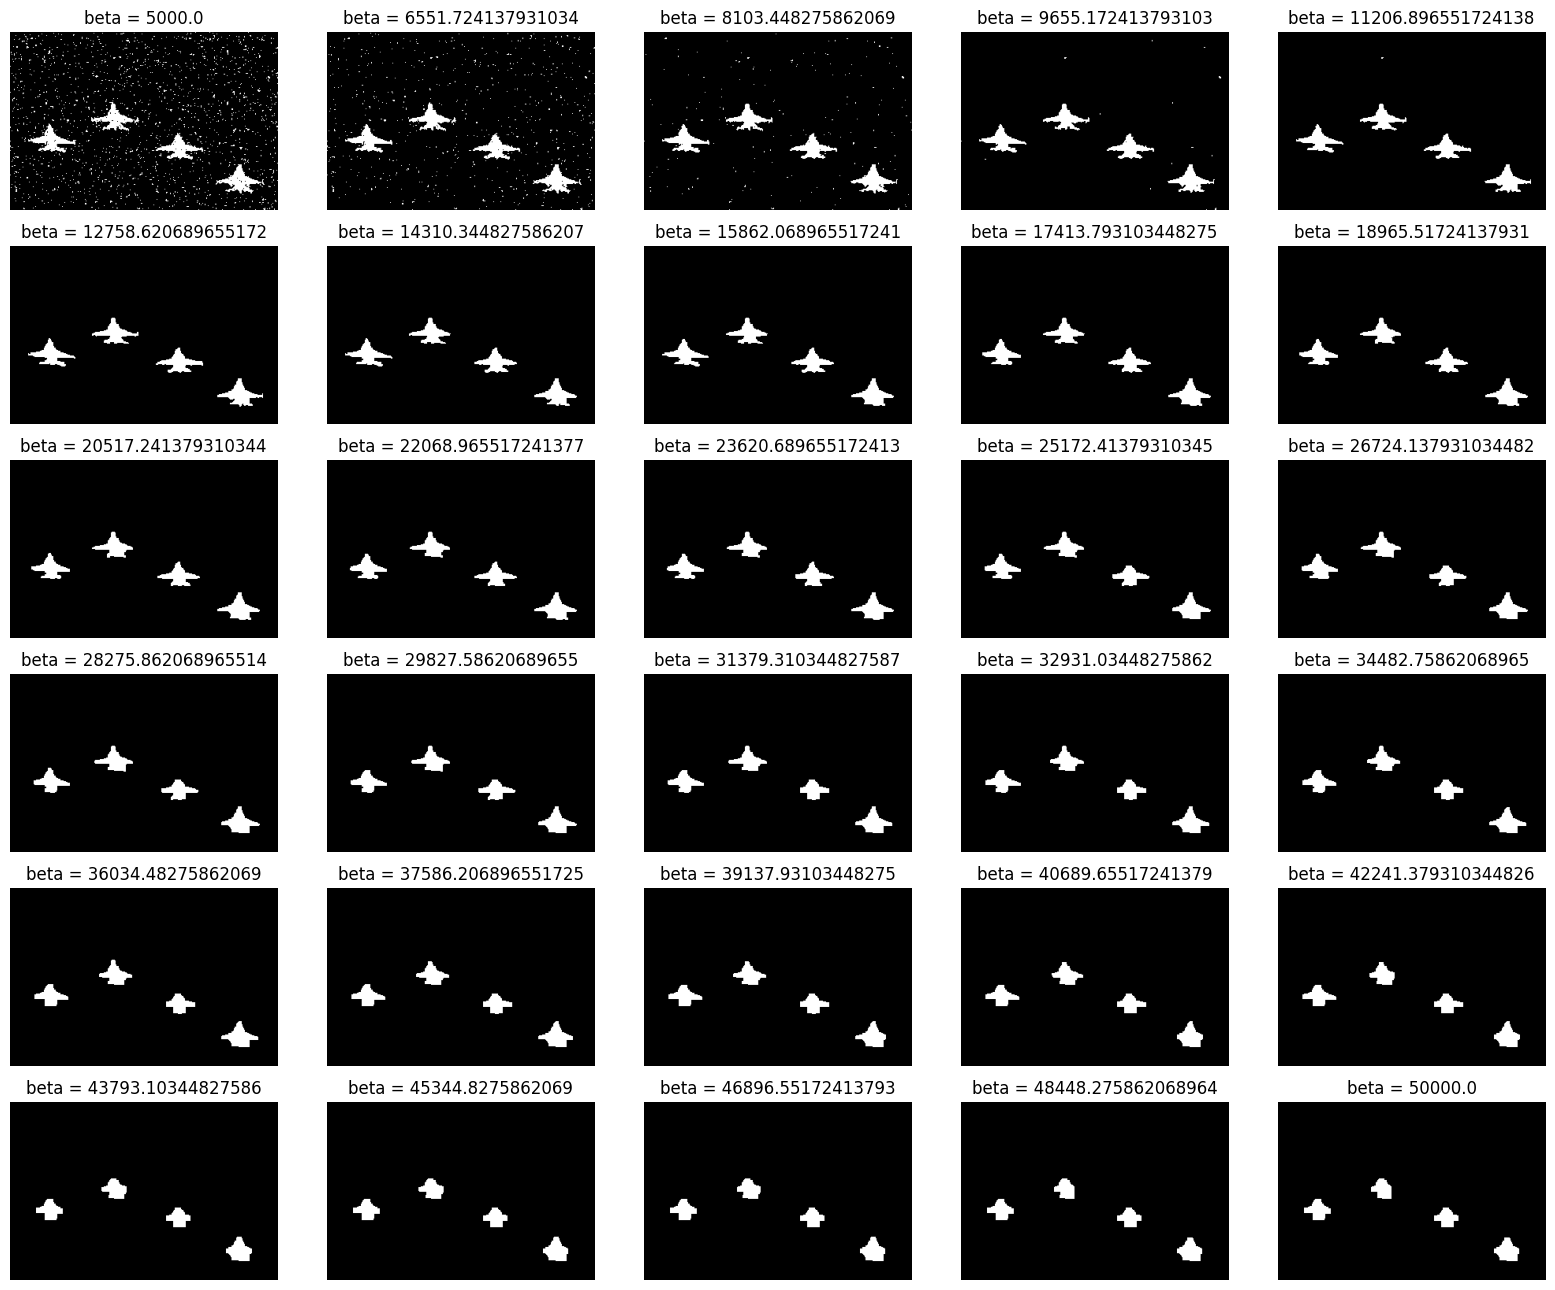

In [41]:
fig,axes = plt.subplots(6,5,figsize = (16,13))
for i in range (6):
  for j in range (5):
    axes[i,j].imshow(list_results[5*i+j],cmap='gray')
    axes[i,j].axis("off")
    axes[i,j].set_title("beta = "+str(list_beta[5*i+j]))
plt.tight_layout()
plt.show()


Given the genral shape of the planes, We assume that the best beta is 14300

(-0.5, 339.5, 225.5, -0.5)

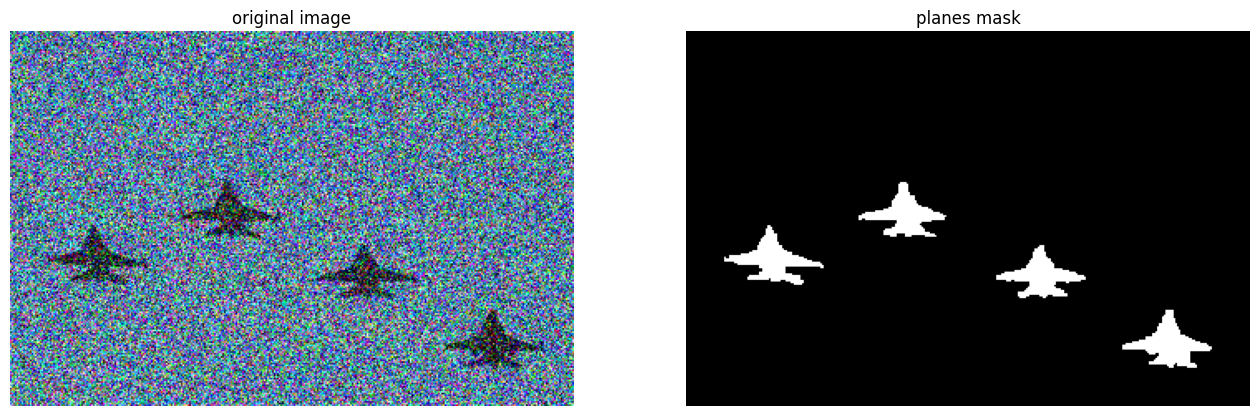

In [43]:
fig,axes= plt.subplots(1,2,figsize=(16,16))
axes[0].imshow(im_planes)
axes[1].imshow(list_results[6],cmap='gray')
axes[0].set_title("original image")
axes[1].set_title("planes mask")
axes[0].axis('off')
axes[1].axis('off')

### 2.2 Use of a CRF (Conditional Random Field) model

We will try here to adapt the model used previously to favour transitions where they are compatible with the gradient. To do this, we will replace the constant $\beta$ for the whole image by a "beta_field" which depends on the norm of the gradient.

Q10: Calculate and display the modulus of the gradient of the aircraft image after it has been grayscaled and convolved by a Gaussian kernel of standard deviation 1. Why use the "boundary='symm'" option when convolving through the Sobel filter? Try it without doing the Gaussian filtering. What is the point?

**Your answer &#x270D;**

A10:
We use the "boundary='symm'"option in order to define the behaviour of the convolution near the edge of the image. For example, in these areas (for example the very first pixel) by using this option we decide that the pixel [-1,0] is the same as pixel [image.shape-1,0] in order to compute the convolution.


We noitice that the gradient norm image without the gaussien filter has alot of false contours due to the noise. In fact in presence of noise we get a sudden change in the values in homogenous areas which translates to big gradient norms. So the gaussien filter helps reduce this fluctuations.

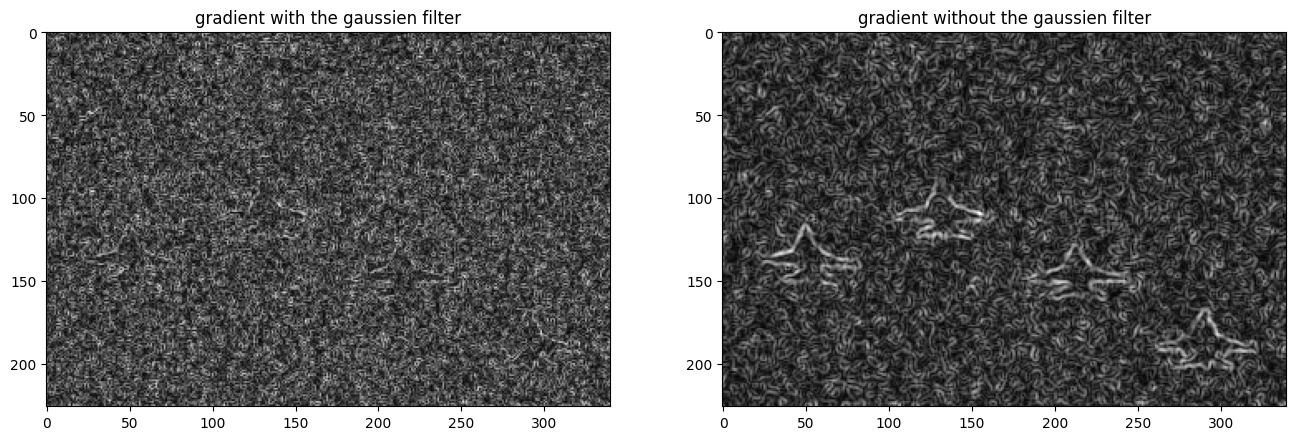

In [44]:
import scipy.signal
import scipy.ndimage
from skimage import color

def gradient(image):
    """ Array -> tuple[Array*Array]"""
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = float)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = float)
    # to be completed


    # use mode = 'same' and boundary='symm' in scipy.signal.convolve2d
    # TO BE COMPLETED
    derivative_x = scipy.signal.convolve2d(image,sobel_x,mode="same",boundary='symm')
    derivative_y = scipy.signal.convolve2d(image,sobel_y,mode="same",boundary='symm')
    return([derivative_x,derivative_y])

plane_nb = scipy.ndimage.gaussian_filter(color.rgb2gray(im_planes), 1)
plane_x, plane_y = gradient(plane_nb)
grad_av = np.sqrt(plane_x**2+plane_y**2)


plane_x_no_gaus, plane_y_no_gaus = gradient(color.rgb2gray(im_planes))
grad_av_no_gaus = np.sqrt(plane_x_no_gaus**2+plane_y_no_gaus**2)

fig,axes = plt.subplots(1,2,figsize=(16,16))

axes[0].imshow(grad_av_no_gaus,cmap="gray")
axes[0].set_title("gradient with the gaussien filter")

axes[1].imshow(grad_av,cmap="gray")
axes[1].set_title("gradient without the gaussien filter")

plt.show()



Complete the code for segmentation by CRF. We will choose $beta\_field=\beta_2\cdot\exp(-grad\_av/h)$ We can use $h=300$ and $\beta_2=20000$. Also replace the constant beta by the field "beta_field" during the "g.add_grid_edges" step.

Q11: Compare the results with and without the contour term.

**Your answer &#x270D;**

A11: With the same value beta = 20000, by adding the weights based on the norm of gradient, we obtain better results especially in the edges of the planes as shown in the comparaison. However since this image is simple the overall difference isn't clear and the first approach still yields an acceptable result

Max Flow: 1096010178.2865467


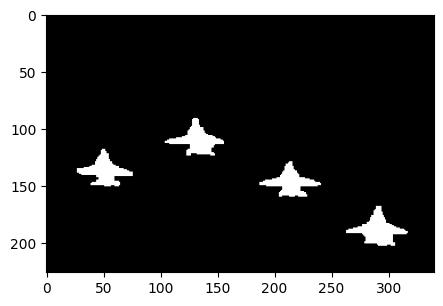

In [45]:

# calcul de beta_field
# ce champ définira la valeur pour les 4-voisins
# TO BE COMPLETED
h =300.
beta2 = 20000.
beta_field = beta2 * np.exp(-grad_av/h)
m_sky=[m0_c0,m0_c1,m0_c2]
m_planes=[m1_c0,m1_c1,m1_c2]
## Graph cut binaire
# compléter en reprenant votre code précédent et en remplaçant
# beta par beta_field dans la ligne g.add_grid_edges
g = maxflow.Graph[float]() #Instanciation du graph

# Add the nodes.
# nodeids has the identifiers of the nodes in the grid.
# It creates a set of nodes for all the pixels of the image
nodeids = g.add_grid_nodes(im_planes.shape[0:2])

# Add non-terminal edges with the same capacity.
# the edge has the value beta for all adjacent pixels in 4-connexity
g.add_grid_edges(nodeids, beta_field)

# Add the terminal edges.
# the second argument correspond to the set of edge values to the source
# the third argument correspond to the set of edge values to the sink
g.add_grid_tedges(nodeids, (im_planes[:,:,0]-m_sky[0])**2+(im_planes[:,:,1]-m_sky[1])**2+(im_planes[:,:,2]-m_sky[2])**2, (im_planes[:,:,0]-m_planes[0])**2+(im_planes[:,:,1]-m_planes[1])**2+(im_planes[:,:,2]-m_planes[2])**2)
#g.add_grid_tedges(nodeids, (im_obs[:,:,0]-m_ciel[0])**2, (im_obs[:,:,0]-m_avions[0])**2)


# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the labels of the nodes in the grid.
# output is 0 if the node is connected to the source, else output is 1
sgm = g.get_grid_segments(nodeids)
im_bin = np.int_(np.logical_not(sgm))

# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids) # Renvoie 1 si le pixel est du coté du drain après calcul de la coupe min, 0 si il est du coté de la source
im_bin_grad = np.int_(np.logical_not(sgm))
plt.rcParams['figure.figsize'] = [5, 20]
plt.imshow(im_bin_grad,cmap="gray")
plt.show()

<Figure size 500x2000 with 0 Axes>

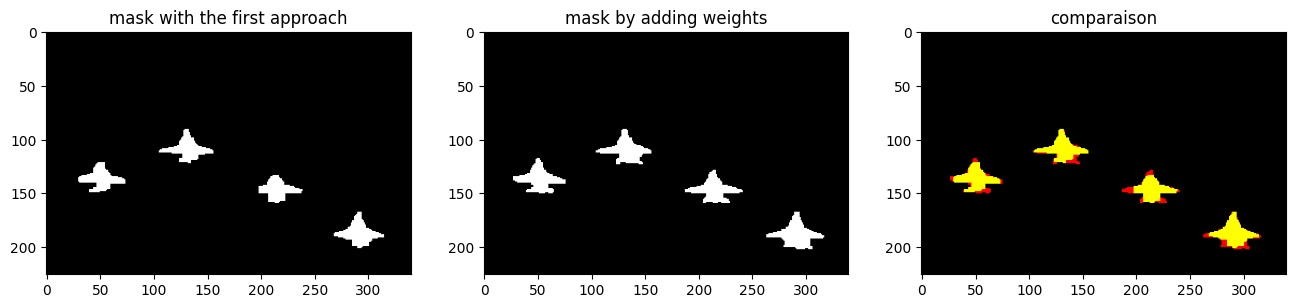

<Figure size 500x2000 with 0 Axes>

In [46]:
beta = 20000
g = maxflow.Graph[float]() # Graph instantiation

nodeids = g.add_grid_nodes((im_planes.shape[0],im_planes.shape[1]))


g.add_grid_edges(nodeids, beta)

g.add_grid_tedges(nodeids, (im_planes[:,:,0]-m0_c0)**2/(2*v0_c0)+ (im_planes[:,:,1]-m0_c1)**2+ (im_planes[:,:,2]-m0_c2)**2, (im_planes[:,:,0]-m1_c0)**2+ (im_planes[:,:,1]-m1_c1)**2+ (im_planes[:,:,2]-m1_c2)**2)

flow = g.maxflow()

#    print("Max Flow:", str(flow))

sgm = g.get_grid_segments(nodeids)
im_bin = np.int_(np.logical_not(sgm))

fig,axes = plt.subplots(1,3,figsize =(16,16))

axes[0].imshow(im_bin,cmap='gray')
axes[0].set_title("mask with the first approach")
axes[1].set_title("mask by adding weights")
axes[1].imshow(im_bin_grad,cmap='gray')
axes[2].set_title("comparaison")
axes[2].imshow(np.dstack(( im_bin_grad, np.int_(im_bin),np.zeros_like(im_bin_grad)))*255)
plt.figure()


## 3. Iterative Segmentation with Gaussian Mixture

Q12: Display the "zebra" image below. Is it possible to segment the zebra with the method used to segment the planes?



**Your answer &#x270D;**

A12: No it is not the same. The difference lies in two aspects: first we can no longer model these distributions as normal distributions since for example in the background we have multiple probable values of green. The second aspect is that the 3 channels are dependent. Here for example in the white part of the zebra we need the three channels together to conclude its class.

uint8


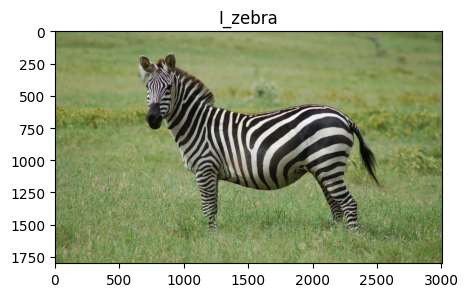

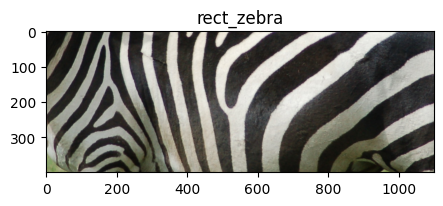

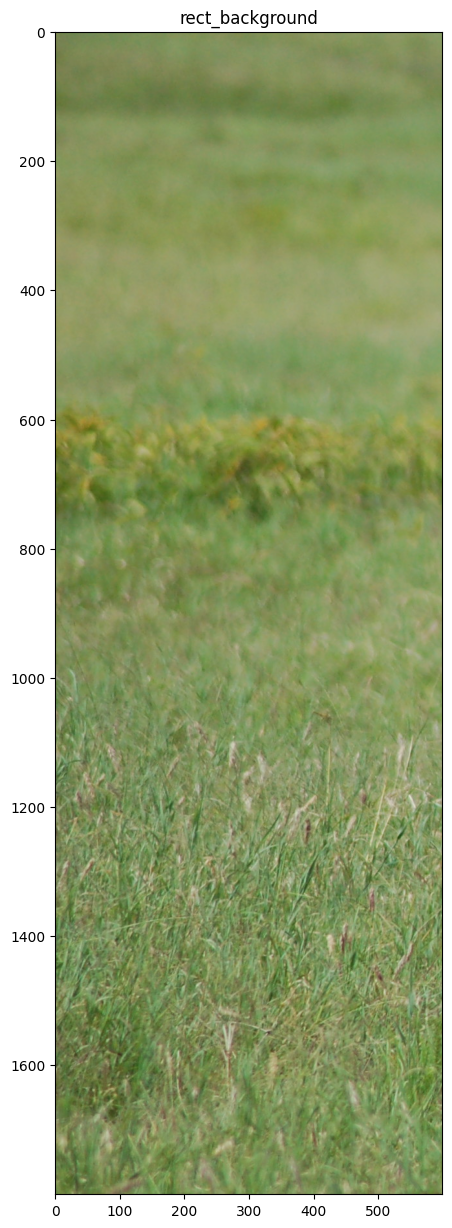

In [17]:
### Loading a new image
I_zebra = io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Equus_quagga.jpg")
I_zebra = I_zebra[200:,:,:]
rect_zebra = I_zebra[700:1100,1000:2100]
rect_background = I_zebra[:,0:600]
print(I_zebra.dtype)

plt.figure()
plt.imshow(I_zebra)
plt.title('I_zebra')
plt.show()

plt.figure()
plt.imshow(rect_zebra)
plt.title('rect_zebra')
plt.show()

plt.figure()
plt.imshow(rect_background)
plt.title('rect_background')
plt.show()

Q13: Calculate the covariance matrix for the rect_zebra and the rect_background. Display the values and comment on the result. What do the diagonal values correspond to?

**Your answer &#x270D;**

A13:
The obtained results shows matrices with non null off diagnol values. This means that there is correlation between the 3 channels.
The diagonal values represent the varinaces of each channel in each case. For the rectangle zebra we get high variance values this is justified by the fact that the image contains either white (all channels have a max value) or black( all channels have the min value) color. However for the background we mostly have green color which translates to low variance

In [21]:
print(I_zebra.shape)
V_tulip = np.vstack([I_zebra[:,:,i].flatten() for i in range(3)])
print(V_tulip.shape)

M_cov_I = np.cov(np.vstack([I_zebra[:,:,i].flatten() for i in range(3)]))
print('Full zebra image')
print(M_cov_I)

M_cov_Z = np.cov(np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]))
print('Rectangle zebra')
print(M_cov_Z)

M_cov_B = np.cov(np.vstack([rect_background[:,:,i].flatten() for i in range(3)]))
print('Rectangle background')
print(M_cov_B)

(1800, 3008, 3)
(3, 5414400)
Full zebra image
[[1505.54438095 1533.04278068 1229.71568017]
 [1533.04278068 1691.10755214 1221.09280991]
 [1229.71568017 1221.09280991 1210.38328951]]
Rectangle zebra
[[5504.73383563 5535.4436469  5290.02896111]
 [5535.4436469  5588.18500866 5329.06646681]
 [5290.02896111 5329.06646681 5143.99751626]]
Rectangle background
[[313.37936128 226.13253307 255.56699124]
 [226.13253307 219.38193629 221.71082516]
 [255.56699124 221.71082516 308.63086939]]


Q14: Display the histogram for the R, G and B channels for the "rect_zebra" image. Comment on the result.

**Your answer &#x270D;**

A14:
For the background image

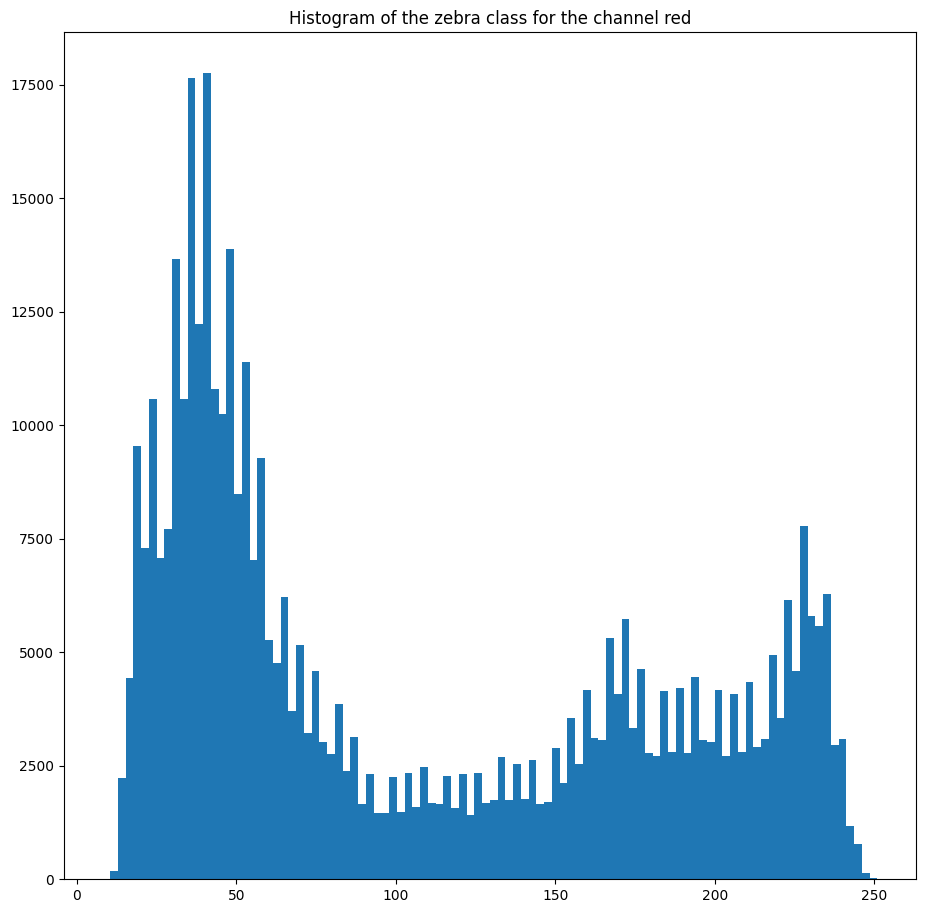

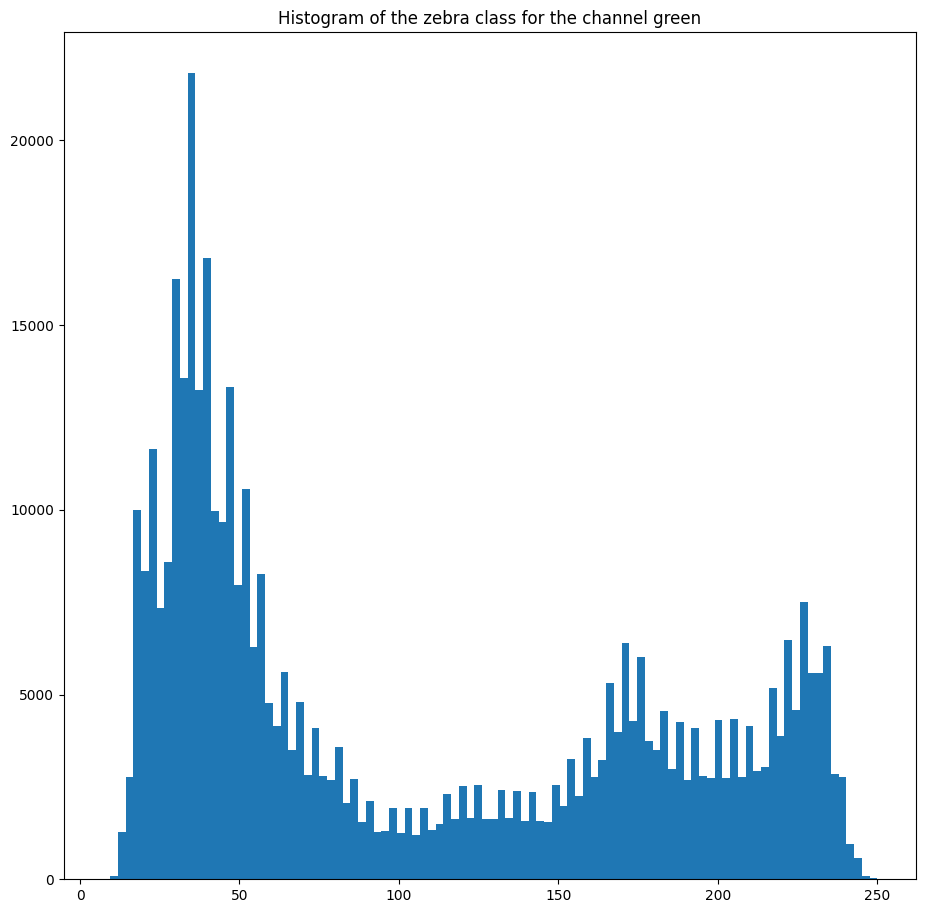

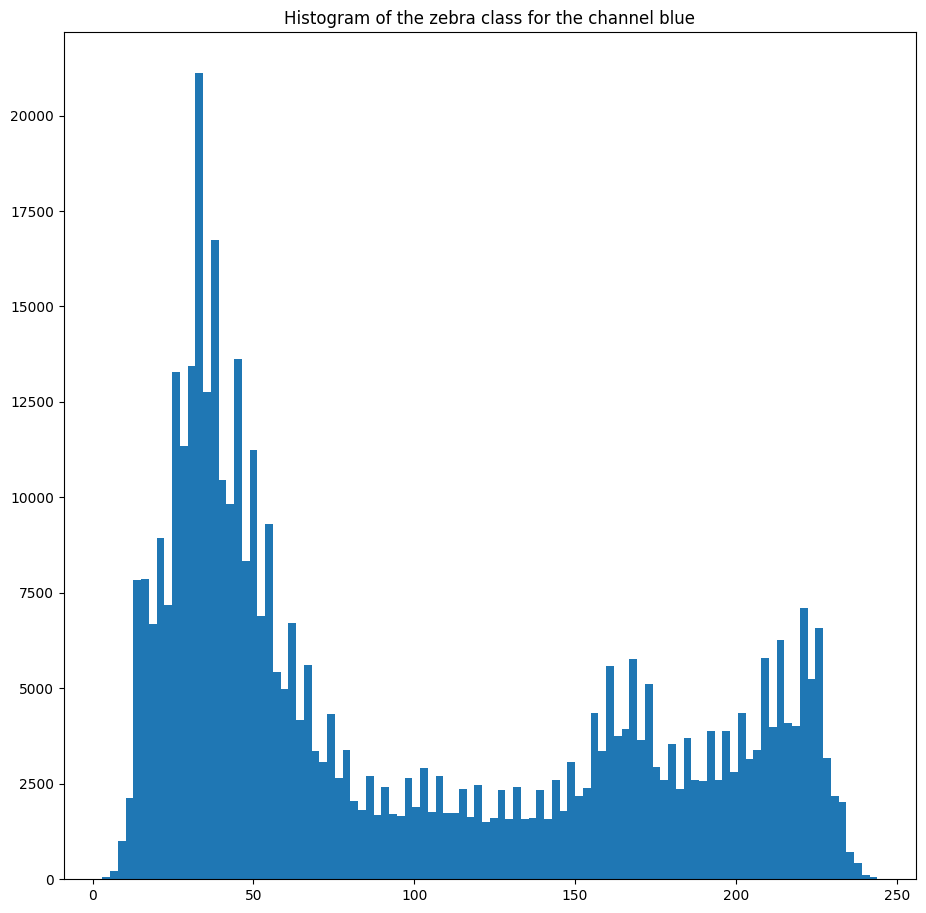

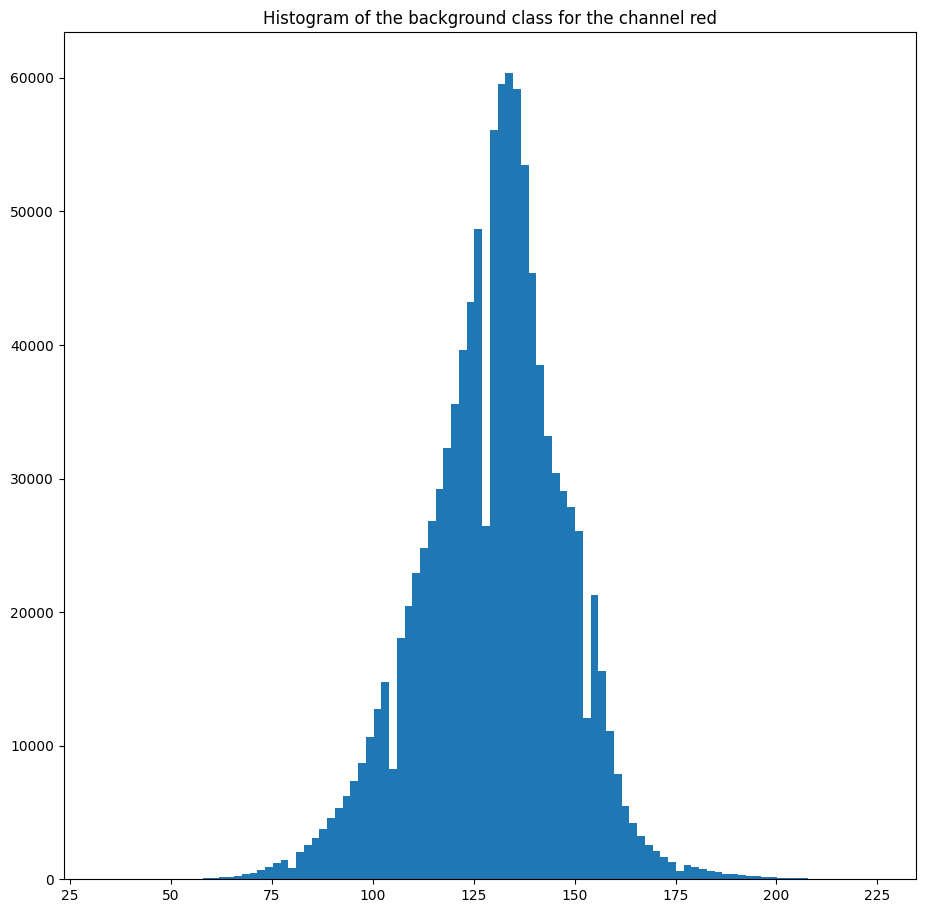

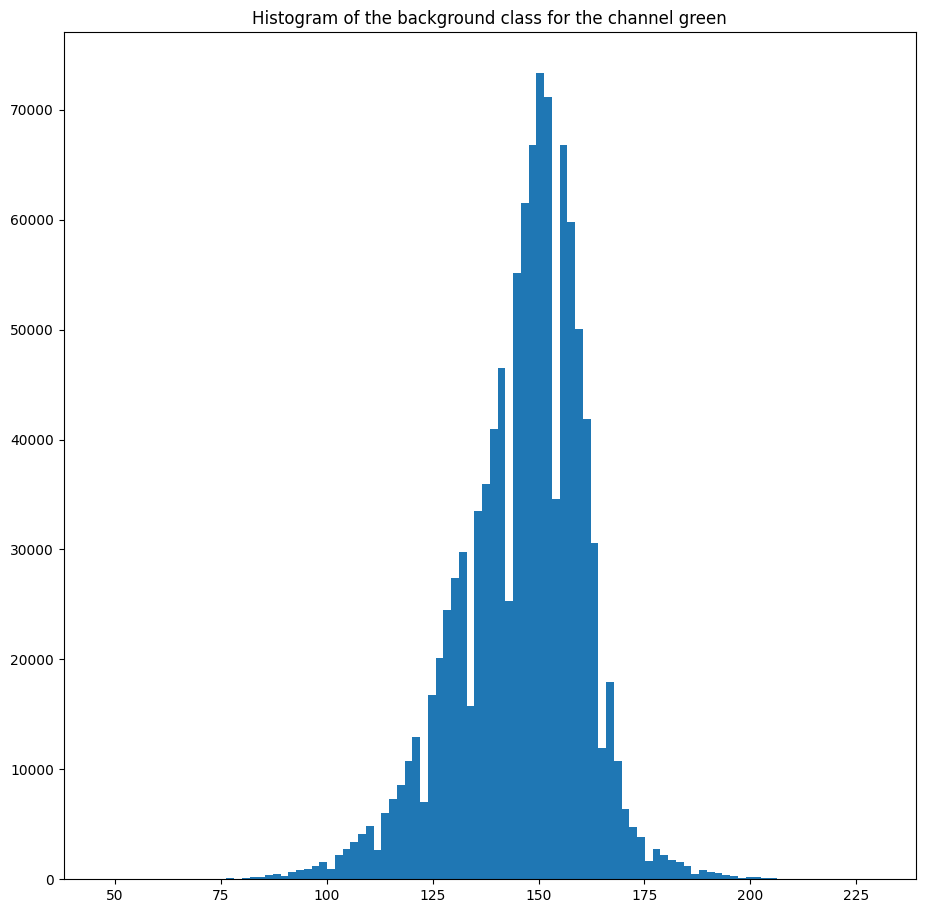

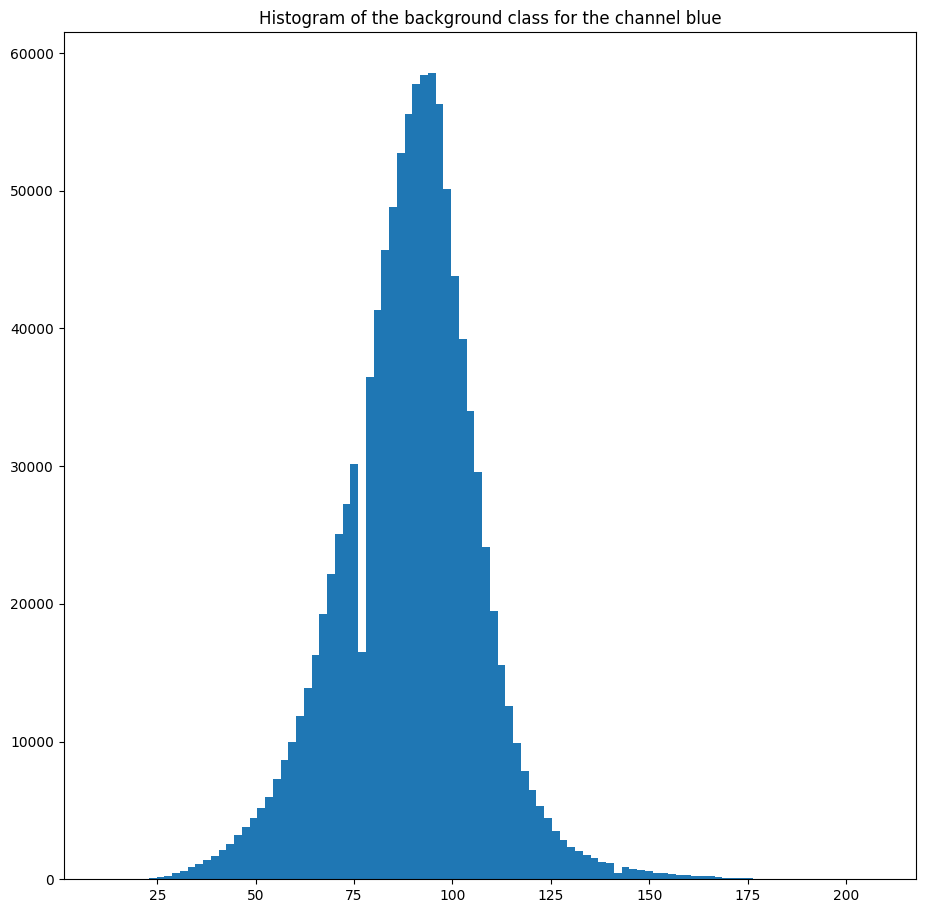

In [22]:
# allows you to change the display size of plt.show
plt.rcParams['figure.figsize'] = [11, 11]

nomchan = ["red","green", "blue"]
for chan in range(3):
    plt.figure()
    plt.hist(rect_zebra[:,:,chan].flatten(),100)
    plt.title("Histogram of the zebra class for the channel " + nomchan[chan])
    plt.show()


for chan in range(3):
    plt.figure()
    plt.hist(rect_background[:,:,chan].flatten(),100)
    plt.title("Histogram of the background class for the channel " + nomchan[chan])
    plt.show()

Q15: Propose an algorithmic method to identify the two classes of the image "rect_zebra". Use a sklearn implementation of this algorithm to identify the mean vectors ($m_R$,$m_G$,$m_B$) for two classes of the "rect_zebra" image and two classes of the "rect_background" image.

*The following line of code can be used to transform the image into a suitable form.*

X = np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]).transpose()

Comment on the average vectors obtained. They can be displayed as an image using the code provided.

**Your answer &#x270D;**

A15:
We can use Kmeans algorithm. We can consider the X vector representing the zebra as 3D points. The we consider that this 3D points can be classified into two classes (white or black). Finally we use the KMeans algorithm in order to get the center of classes and we then can classifier the image points accordingly. For the background, we noitice that it is somehow homegneous(this is also confirmed by the histograms ).

The results shows that for the zebra the two center classes correspond to two gray levels (all channels are equal). For the background, we noitice that we get two variants of green which is also expected due to the overall nature of the background


In [25]:
# computation of class parameters in a semi-automatic way
from sklearn.cluster import KMeans
import numpy as np

# use a number of classes =2 for the zebra part (complete n_clusters=?)
X = np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]).transpose()
kmeans_zebra = KMeans(n_clusters=2, random_state=0).fit(X)
mean_vectors_zebra = kmeans_zebra.cluster_centers_

# use a number of classes =2 for the background part
X = np.vstack([rect_background[:,:,i].flatten() for i in range(3)]).transpose()
kmeans_background = KMeans(n_clusters=2, random_state=0).fit(X)
mean_vectors_background = kmeans_background.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


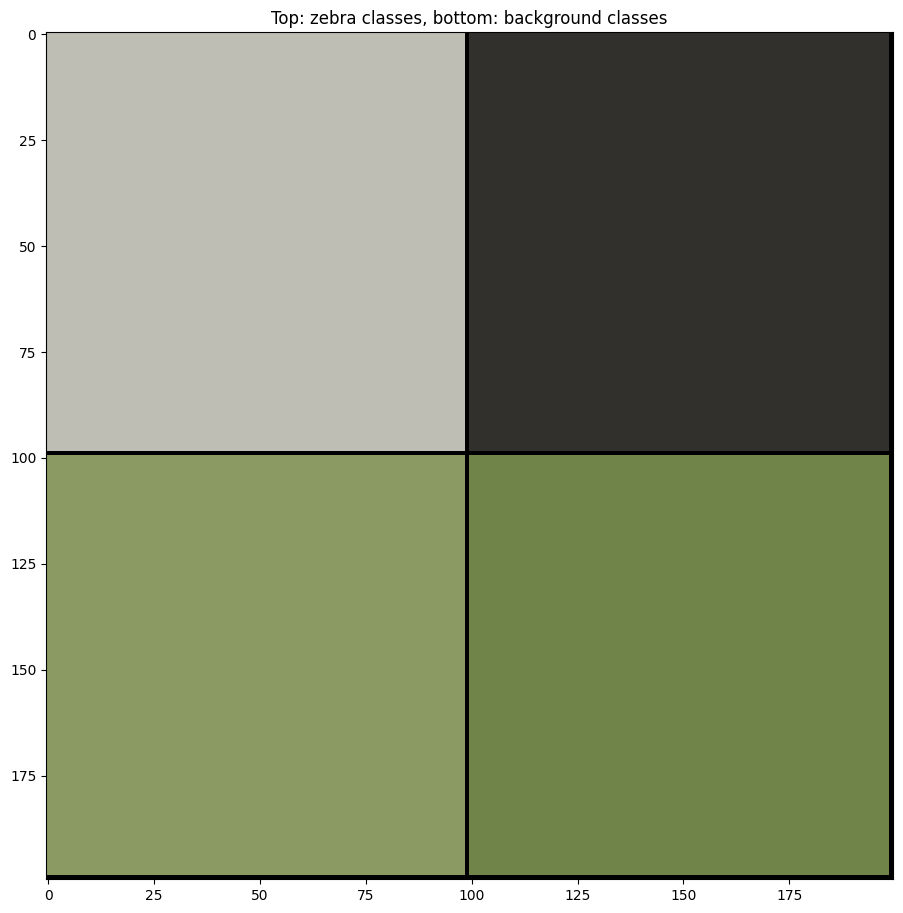

In [26]:
# display of the class centers found as an image
image_mean_vectors = np.zeros((200,200,3),np.uint8)
for i in range(3):
    image_mean_vectors[0:99,0:99,i] = mean_vectors_zebra[0,i]
    image_mean_vectors[0:99,100:199,i] = mean_vectors_zebra[1,i]
    image_mean_vectors[100:199,0:99,i] = mean_vectors_background[0,i]
    image_mean_vectors[100:199,100:199,i] = mean_vectors_background[1,i]

plt.figure()
plt.imshow(image_mean_vectors,vmax = 255)
plt.title("Top: zebra classes, bottom: background classes")
plt.show()

Q16: Display separately two neg-log-likelihood images (the neg-log-likelihood was used as a data attachment in the previous example) for the two zebra classes.
Build a neg-log-likelihood image corresponding to the minimum of the two neg-log-likelihoods of the zebra classes. Similarly for the background class.

Display them and comment.

**Your answer &#x270D;**

A16:
Here, in the neg-log-likelihood we are computing at each pixel the distance between that pixel to the center of the class that we found earlier.
By doing so we can get a mesure of how close we are to that center. The lower the value the closer we are to that center the more likely the pixel is in that class (hence the name neg-log-likelihood)
by computing the minimum of the two neg-log-likelihoods we are searching for the image that is close to one of the two centers meaning that we are searching for the neg-log-likelhood of being a pixel of the zebra.  The results obtained shows that the darker the values the more likely the pixel is part of the zebra. However in the last image, we noitice that the results has some false parts that this method consider as zebra. This is due to the fact that even in the background, some pixels have values close to one of the centers (think about the shades of the animal having black color, or some white values due white flowers or sun reflection). So, the results can contain some false classification due to method used.

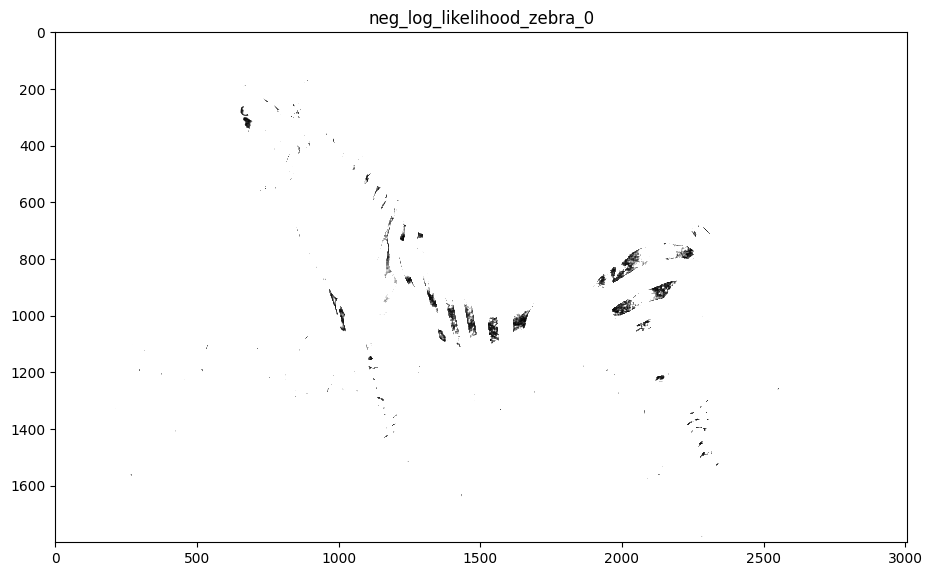

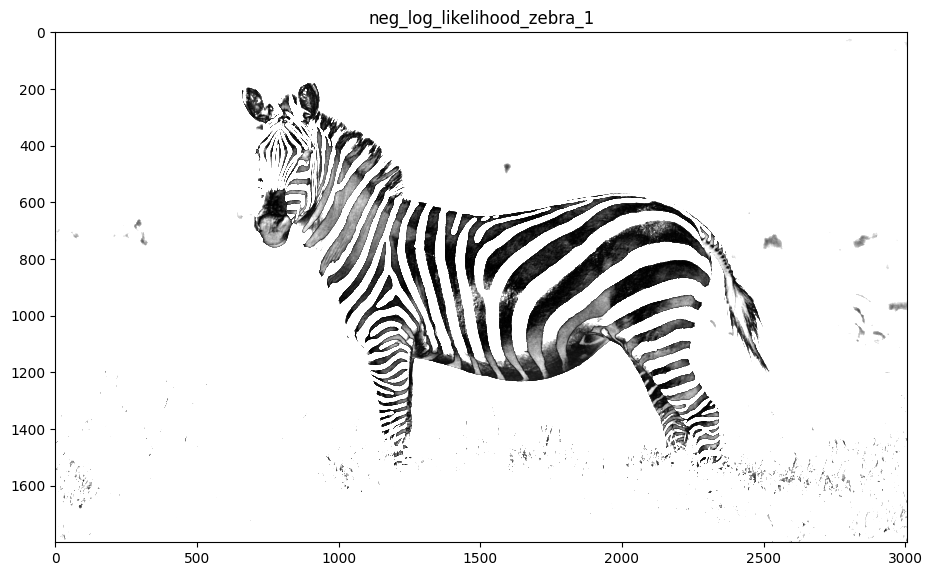

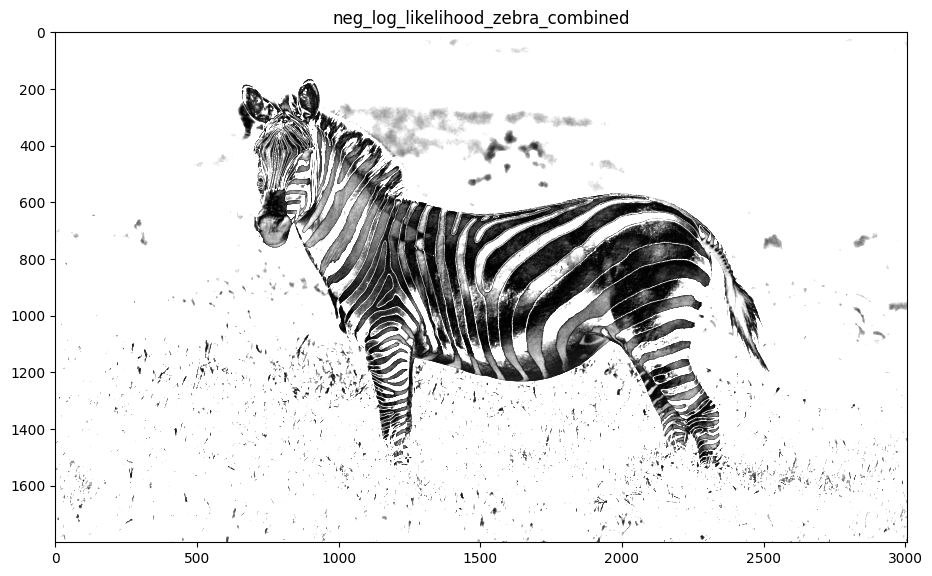

In [27]:
# calculation of the neg-log-likelihood of the zebra class
neg_log_likelihood_zebra_0 = sum((I_zebra[:,:,i]-mean_vectors_zebra[0,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_zebra_0,cmap='gray', vmax = 600)
plt.title("neg_log_likelihood_zebra_0")
plt.show()

neg_log_likelihood_zebra_1 = sum((I_zebra[:,:,i]-mean_vectors_zebra[1,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_zebra_1,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_zebra_1")
plt.show()

neg_log_likelihood_zebra_combined = np.minimum(sum((I_zebra[:,:,i]-mean_vectors_zebra[0,i])**2 for i in range(3)),sum((I_zebra[:,:,i]-mean_vectors_zebra[1,i])**2 for i in range(3)))

plt.figure()
plt.imshow(neg_log_likelihood_zebra_combined,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_zebra_combined")
plt.show()

# TO BE COMPLETED
# calculate the neg-log-likelihood of the background
# call the output neg_log_likelihood_background_combined





Q17: From these combined data attachment images (one for the background and one for the zebra), set up a graph-cut segmentation of the image with the $\beta$ of your choice. Comment the result.

**Your answer &#x270D;**

A17: By adding a regularistaion term and computing the minimzer of the energy function we get a much better segmentation. In fact, we get rid of the false classification in the background. However, it is clear that this segmentation is not perfect. The behviour near the board of the zebra needs to be further enhanced

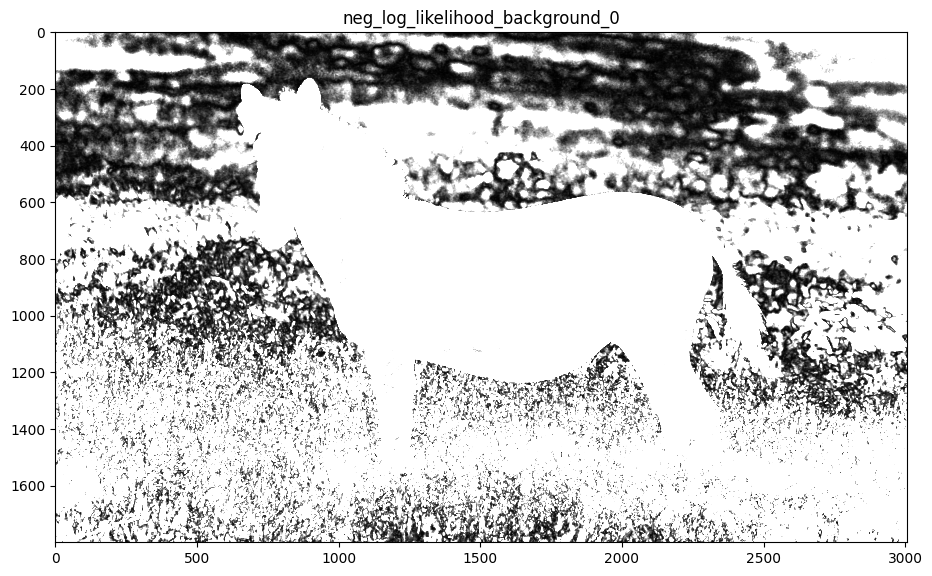

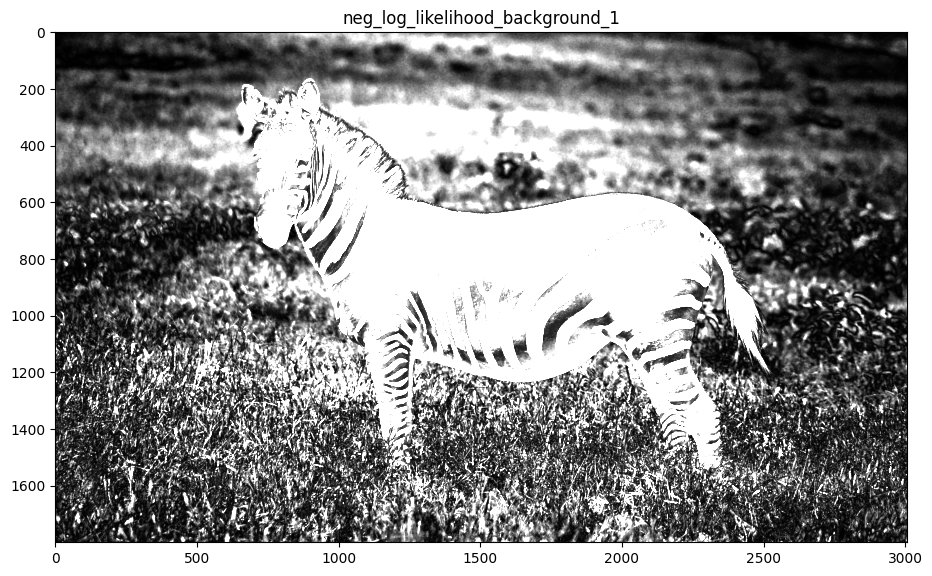

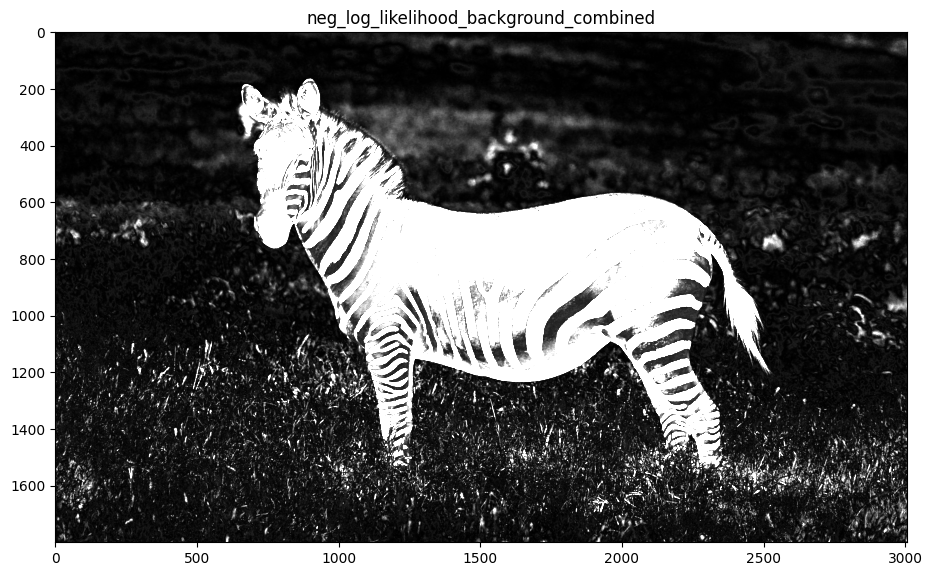

In [28]:
# calculation of the neg-log-likelihood of the zebra class
neg_log_likelihood_background_0 = sum((I_zebra[:,:,i]-mean_vectors_background[0,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_background_0,cmap='gray', vmax = 600)
plt.title("neg_log_likelihood_background_0")
plt.show()

neg_log_likelihood_background_1 = sum((I_zebra[:,:,i]-mean_vectors_background[1,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_background_1,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_background_1")
plt.show()

neg_log_likelihood_background_combined = np.minimum(sum((I_zebra[:,:,i]-mean_vectors_background[0,i])**2 for i in range(3)),sum((I_zebra[:,:,i]-mean_vectors_background[1,i])**2 for i in range(3)))

plt.figure()
plt.imshow(neg_log_likelihood_background_combined,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_background_combined")
plt.show()

# TO BE COMPLETED
# calculate the neg-log-likelihood of the background
# call the output neg_log_likelihood_background_combined



Max Flow: 7249738265.928412


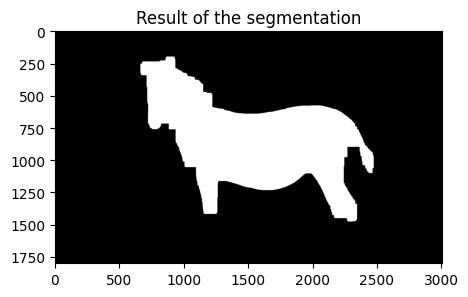

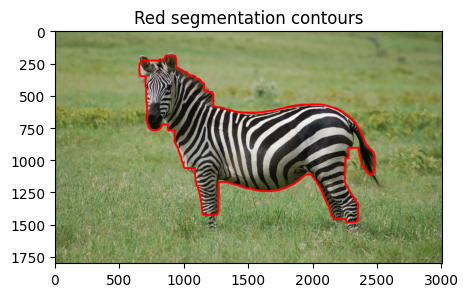

In [52]:
beta = 250000  # Optimal beta value to be determined

## Binary graph cut

# Create the graph.
g = maxflow.Graph[float]() # Graph instantiation
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(I_zebra.shape[0:2]) # Create a grid with a non-terminal node for each pixel in the image
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, beta) # Addition of a beta weight edge between each adjacent node according to the 4-connexity
# Add the terminal edges.

# TO BE COMPLETED
g.add_grid_tedges(nodeids,neg_log_likelihood_background_combined,neg_log_likelihood_zebra_combined )


# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
im_bin = np.int_(np.logical_not(sgm))

plt.figure()
plt.imshow(im_bin,cmap='gray')
plt.title("Result of the segmentation")
plt.show()

plt.figure()
plt.imshow(display_segmentation_borders(I_zebra, im_bin))
plt.title("Red segmentation contours")
plt.show()

Q18: From the obtained segmentation, determine the mean vectors for 5 classes for the background and 5 classes for the zebra. Use these lists of mean vectors to construct new neg-log-likelihood combination images. Comment on them.

**Your answer &#x270D;**

A18: The new neg-log-likelihood images are more refined and give more accurate segmentation

In [53]:
# The computing of this cell can take several minutes.

X_1 = np.vstack([I_zebra[im_bin==1,i].flatten() for i in range(3)]).transpose()
kmeans_zebra2 = KMeans(n_clusters=5, random_state=0).fit(X_1)
mean_vectors_zebra2 = kmeans_zebra2.cluster_centers_

X_2 = np.vstack([I_zebra[im_bin==0,i].flatten() for i in range(3)]).transpose()
kmeans_background2 = KMeans(n_clusters=5, random_state=0).fit(X_2)
mean_vectors_background2 = kmeans_background2.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


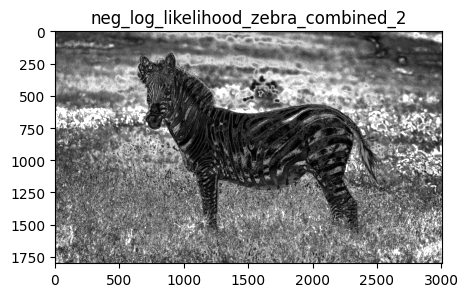

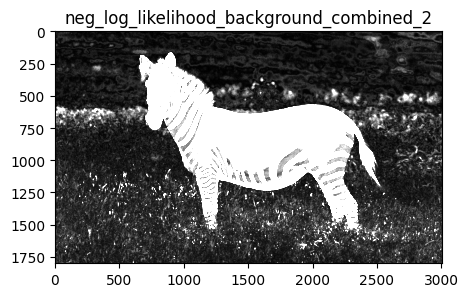

In [54]:
neg_log_likelihood_zebra_combined_2 = np.amin(np.dstack([(sum((I_zebra[:,:,i]-mean_vectors_zebra2[n_cl,i])**2 for i in range(3))) for n_cl in range(len(mean_vectors_zebra2))]),2)

neg_log_likelihood_background_combined_2 = np.amin(np.dstack([(sum((I_zebra[:,:,i]-mean_vectors_background2[n_cl,i])**2 for i in range(3))) for n_cl in range(len(mean_vectors_background2))]),2)

plt.figure()
plt.imshow(neg_log_likelihood_zebra_combined_2 ,cmap='gray', vmax = 3000)
plt.title("neg_log_likelihood_zebra_combined_2")
plt.show()

plt.figure()
plt.imshow(neg_log_likelihood_background_combined_2,cmap='gray', vmax = 1000)
plt.title("neg_log_likelihood_background_combined_2")
plt.show()


Q19: From these neg-log-likelihood images, segment the image by graph-cut using a new value of $\beta$ that gives you the best result. Comment on the result and the new value of $\beta$ that allowed you to obtain it. What about the new 5-class data attachment compared to the previous one?

**Your answer &#x270D;**

A19:
The results are much more accurate now. Using more classes in each case allows us to better identify wether the pixel is a part of the zebra or the background.
The value of beta now is 13000 compared to 250000 previously. This is due to the fact that now we need much less regularisation since our data attachement model is more accurate. This was not the case previously.

Max Flow: 1463659727.6824868


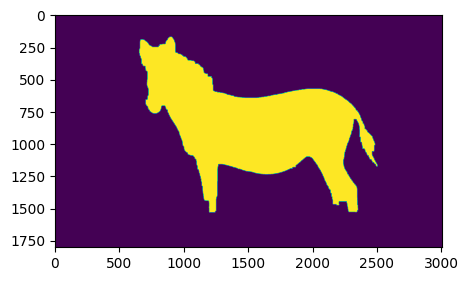

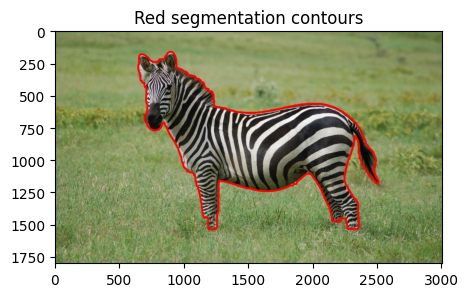

In [56]:
beta = 13000  # Optimal beta value to be determined

g = maxflow.Graph[float]() # Graph instantiation
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(I_zebra.shape[0:2])
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, beta)
# Add the terminal edges.
g.add_grid_tedges(nodeids,neg_log_likelihood_background_combined_2, neg_log_likelihood_zebra_combined_2)

flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids) # Returns 1 if the pixel is on the drain side after calculation of the min cut, 0 if it is on the source side
im_bin = np.int_(np.logical_not(sgm))

plt.figure()
plt.imshow(im_bin)
plt.show()

plt.figure()
plt.imshow(display_segmentation_borders(I_zebra, im_bin))
plt.title("Red segmentation contours")
plt.show()